http://apptwitter-env.eba-dbici4gv.us-east-2.elasticbeanstalk.com/tweets?a%C3%B1o=2023

In [1]:
import pandas as pd
import json
import pymysql

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem.snowball import SnowballStemmer

import demoji
demoji.download_codes()

import pickle

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\JI\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.


## Cargamos tweets_2022

In [2]:
# 60 filas

with open('data/tweets_2022.json') as file:
    data_22 = json.load(file)

# Tweets
df_22 = pd.DataFrame(data_22['data'])

df_22["author_id"] = df_22["author_id"].astype(str)
df_22["created_at"] = pd.to_datetime(df_22["created_at"])
df_22["id"] = df_22["id"].astype(str)
df_22["text"] = df_22["text"].astype(str)
df_22["impression_count"] = df_22["public_metrics"].apply(lambda x: x["impression_count"])
df_22["like_count"] = df_22["public_metrics"].apply(lambda x: x["like_count"])
df_22["quote_count"] = df_22["public_metrics"].apply(lambda x: x["quote_count"])
df_22["reply_count"] = df_22["public_metrics"].apply(lambda x: x["reply_count"])
df_22["retweet_count"] = df_22["public_metrics"].apply(lambda x: x["retweet_count"])

df_22.drop(columns=["public_metrics"], inplace=True)
df_22_t = df_22

# Usuarios
df_22_u = pd.DataFrame(data_22['includes']['users'])

df_22 = df_22.merge(df_22_u, left_on='author_id', right_on='id')

df_22.drop(columns=['id_y', 'edit_history_tweet_ids'], inplace=True)

df_22.rename(columns={'id_x':'id_message'}, inplace=True)

df_22 = df_22[['id_message', 'text', 'created_at', 'author_id', 'name', 'username', 'retweet_count', 'reply_count', 'like_count', 'quote_count', 'impression_count']]

## Cargamos tweets_2023

In [3]:
# 89

with open('data/tweets_2023.json') as file:
    data_23 = json.load(file)

# Tweets
df_23 = pd.DataFrame(data_23['data'])

df_23["author_id"] = df_23["author_id"].astype(str)
df_23["created_at"] = pd.to_datetime(df_23["created_at"])
df_23["id"] = df_23["id"].astype(str)
df_23["text"] = df_23["text"].astype(str)
df_23["impression_count"] = df_23["public_metrics"].apply(lambda x: x["impression_count"])
df_23["like_count"] = df_23["public_metrics"].apply(lambda x: x["like_count"])
df_23["quote_count"] = df_23["public_metrics"].apply(lambda x: x["quote_count"])
df_23["reply_count"] = df_23["public_metrics"].apply(lambda x: x["reply_count"])
df_23["retweet_count"] = df_23["public_metrics"].apply(lambda x: x["retweet_count"])

df_23.drop(columns=["public_metrics"], inplace=True)
df_23_t = df_23

# Usuarios
df_23_u = pd.DataFrame(data_23['includes']['users'])

df_23 = df_23.merge(df_23_u, left_on='author_id', right_on='id')

df_23.drop(columns=['id_y', 'edit_history_tweet_ids'], inplace=True)

df_23.rename(columns={'id_x':'id_message'}, inplace=True)

df_23 = df_23[['id_message', 'text', 'created_at', 'author_id', 'name', 'username', 'retweet_count', 'reply_count', 'like_count', 'quote_count', 'impression_count']]

## Validamos rango de fechas

In [4]:
print("Filas 2022:",len(df_22))
print("Filas 2023:",len(df_23))
print()
print('Min 2022:', df_22['created_at'].min())
print('Max 2022:', df_22['created_at'].max())
print()
print('Min 2023:', df_23['created_at'].min())
print('Max 2023:', df_23['created_at'].max())

Filas 2022: 60
Filas 2023: 89

Min 2022: 2022-11-22 08:01:31+00:00
Max 2022: 2022-12-29 16:39:19+00:00

Min 2023: 2023-01-02 15:15:00+00:00
Max 2023: 2023-03-07 17:16:14+00:00


## Unimos 2022 y 2023

In [5]:
df = pd.concat([df_22, df_23])
len(df)

149

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 88
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id_message        149 non-null    object             
 1   text              149 non-null    object             
 2   created_at        149 non-null    datetime64[ns, UTC]
 3   author_id         149 non-null    object             
 4   name              149 non-null    object             
 5   username          149 non-null    object             
 6   retweet_count     149 non-null    int64              
 7   reply_count       149 non-null    int64              
 8   like_count        149 non-null    int64              
 9   quote_count       149 non-null    int64              
 10  impression_count  149 non-null    int64              
dtypes: datetime64[ns, UTC](1), int64(5), object(5)
memory usage: 14.0+ KB


In [7]:
df.describe()

,retweet_count,reply_count,like_count,quote_count,impression_count
count,149.000000,149.000000,149.000000,149.000000,149.000000
mean,1.563758,0.295302,5.449664,0.167785,1732.617450
std,4.236779,0.775498,26.302923,0.537797,18487.232284
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,0.000000,3.000000,0.000000,58.000000
75%,2.000000,0.000000,4.000000,0.000000,218.000000
max,49.000000,7.000000,321.000000,4.000000,225761.000000


In [8]:
len(df['text'].max())

276

## Creación BBDD SQL

### Parámetros de conexión

In [9]:
username_bbdd = "admin"
password = <password>
host = <host>
port = 3306
database="tweets_bbdd"

### Creamos database y tablas

In [26]:
db = pymysql.connect(host = host,
                    user = username_bbdd,
                    password = password,
                    port = port,
                    cursorclass = pymysql.cursors.DictCursor)

cursor = db.cursor()

#Create database
create_db = '''CREATE DATABASE tweets_bbdd'''
cursor.execute(create_db)
cursor.connection.commit()

#Select database and create table
use_db = ''' USE tweets_bbdd'''
cursor.execute(use_db)

# CREATE ALTER
create_table = '''
CREATE TABLE tweets (
    id_message VARCHAR(20) NOT NULL,
    text  VARCHAR(500),
    created_at VARCHAR(30),
    author_id  VARCHAR(20),
    retweet_count INT,
    reply_count INT,
    like_count INT,
    quote_count INT,
    impression_count INT,
    primary key (id_message)
)
'''
cursor.execute(create_table)
db.commit()

create_table = '''
CREATE TABLE users_tweet (
    author_id  VARCHAR(20) NOT NULL,
    name  VARCHAR(20),
    username  VARCHAR(20),
    primary key (author_id)
)
'''
cursor.execute(create_table)

db.commit()
db.close()

### Creamos función para realizar los INSERT

In [144]:
def insert_db(id_message, text, created_at, author_id, name, username, retweet_count, reply_count, like_count, quote_count, impression_count):
    db = pymysql.connect(host = host,
                        user = username_bbdd,
                        password = password,
                        port = port,
                        database = database,
                        cursorclass = pymysql.cursors.DictCursor
                        )

    cursor = db.cursor()
    
    insert_data = '''
    INSERT INTO tweets (id_message, texto, created_at, author_id, retweet_count, reply_count, like_count, quote_count, impression_count)
    VALUES ('%s', '%s', '%s', '%s', '%s', '%s', '%s', '%s', '%s')
    ''' % (id_message, text, created_at, author_id, retweet_count, reply_count, like_count, quote_count, impression_count)

    cursor.execute(insert_data)
    db.commit()

    insert_data = '''
    INSERT INTO users_tweet (author_id, name, username)
    VALUES ('%s', '%s', '%s')
    ''' % (author_id, name, username)

    cursor.execute(insert_data)
    db.commit()

    db.close()

### Eliminamos base de datos

In [25]:
db = pymysql.connect(host = host,
                    user = username_bbdd,
                    password = password,
                    port = port,
                    database = database,
                    cursorclass = pymysql.cursors.DictCursor)

cursor = db.cursor()

insert_data = '''DROP TABLE tweets'''
cursor.execute(insert_data)
# db.commit()

insert_data = '''DROP TABLE users_tweet'''
cursor.execute(insert_data)
# db.commit()

insert_data = '''DROP DATABASE tweets_bbdd'''
cursor.execute(insert_data)
db.commit()

db.close()

### Eliminamos contenido de las tablas

In [11]:
db = pymysql.connect(host = host,
                    user = username_bbdd,
                    password = password,
                    port = port,
                    database = database,
                    cursorclass = pymysql.cursors.DictCursor)

cursor = db.cursor()


insert_data = '''DELETE FROM tweets'''
cursor.execute(insert_data)
# db.commit()

insert_data = '''DELETE FROM users_tweet'''
cursor.execute(insert_data)

db.commit()
db.close()

### Insertamos los datos en las tablas

In [10]:
# df_insert = df
# insert_db(df_insert['id_message'], df_insert['text'], df_insert['created_at'], df_insert['author_id'], df_insert['name'], df_insert['username'], df_insert['retweet_count'], df_insert['reply_count'], df_insert['like_count'], df_insert['quote_count'], df_insert['impression_count'])

In [10]:
df_tweets = df[['id_message', 'text', 'created_at', 'author_id', 'retweet_count', 'reply_count', 'like_count', 'quote_count', 'impression_count']]
df_users = df[['author_id', 'name', 'username']]

In [11]:
# df_users.duplicated(subset='author_id').value_counts()
df_users.drop_duplicates(subset='author_id', inplace=True)

In [12]:
db = pymysql.connect(host = host,
                        user = username_bbdd,
                        password = password,
                        port = port,
                        database = database,
                        cursorclass = pymysql.cursors.DictCursor
                        )

cursor = db.cursor()

In [28]:
# Creación de una lista de columnas para la inserción
cols_tweets = "`,`".join([str(i) for i in df_tweets.columns.tolist()])
cols_users = "`,`".join([str(i) for i in df_users.columns.tolist()])

# Inserta las filas del DataFrame uno a uno
for i, row in df_tweets.iterrows():
    sql = "INSERT INTO `tweets` (`" +cols_tweets + "`) VALUES (" + "%s,"*(len(row)-1) + "%s)"
    cursor.execute(sql, tuple(row))
    db.commit()

for i, row in df_users.iterrows():
    sql = "INSERT INTO `users_tweet` (`" +cols_users + "`) VALUES (" + "%s,"*(len(row)-1) + "%s)"
    cursor.execute(sql, tuple(row))
    db.commit()

db.close()

### Mostramos los datos en un df

In [12]:
db = pymysql.connect(host = host,
                     user = username_bbdd,
                     password = password,
                     port = port,
                     database = database,
                     cursorclass = pymysql.cursors.DictCursor
)

cursor = db.cursor()

In [14]:
cursor.execute('SELECT VERSION()')
version = cursor.fetchone()
print(f'MySQL version: {version}')

MySQL version: {'VERSION()': '8.0.28'}


In [16]:
# use_db = ''' USE tweets_bbdd'''
# cursor.execute(use_db)

In [15]:
sql = '''SELECT * FROM tweets'''
cursor.execute(sql)
tweets = cursor.fetchall()
pd.DataFrame(tweets)

,id_message,text,created_at,author_id,retweet_count,reply_count,like_count,quote_count,impression_count
0,1594964278238654471,"Aprende hoy las profesiones del futuro, ¡inscr...",2022-11-22 08:01:31+00:00,702077405045899264,2,0,2,0,0
1,1594965197613322241,"Ikasi gaur etorkizuneko lanbideak, izena eman ...",2022-11-22 08:05:10+00:00,702077405045899264,1,0,2,0,0
2,1594968601265586178,Acelerando juntos el #talentodigital en España...,2022-11-22 08:18:42+00:00,783248945761910788,1,1,3,0,0
3,1595359906747617280,¡Ven a conocer los BBK bootcamps powered by @T...,2022-11-23 10:13:36+00:00,1162694149956603904,4,0,3,0,0
4,1595752907684843520,🔵Acelera tu carrera digital con #BBKBootcamps....,2022-11-24 12:15:15+00:00,823470817963032576,3,0,4,0,0
...,...,...,...,...,...,...,...,...,...
144,1632147141224275970,@nodosenlared @snowded @TheBridge_Tech Muy bue...,2023-03-04 22:32:56+00:00,925597948410580993,0,0,1,0,35
145,1632664546665025536,"Encuentro de la @mlopscommunity en Madrid: ""ML...",2023-03-06 08:48:56+00:00,41545659,1,0,3,0,90
146,1632692120719859712,¡Por fin podemos publicar el cartel con los po...,2023-03-06 10:38:30+00:00,1585726199485140993,3,1,5,1,950
147,1632692123412594688,Las inscripciones se realizarán por Eventbrite...,2023-03-06 10:38:30+00:00,1585726199485140993,0,0,0,0,31


In [16]:
sql = '''SELECT * FROM users_tweet'''
cursor.execute(sql)
users_tweet = cursor.fetchall()
pd.DataFrame(users_tweet)

,author_id,name,username
0,1003872445,Pau Mugarra,PauMugarra
1,10279282,Jesús Pérez Serna,mkpositivo
2,106344840,Cámara de Comercio d,camaradesevilla
3,1065627197115981824,AQUADAT,Aqua_Radar
4,1068424025356021760,🐣 Ari 🐙,Ari_Reinventada
...,...,...,...
59,874916978665938945,Startup Valencia,Startup_VLC
60,91876265,Diana Damas (ella/sh,ddamasd
61,921670812637257728,VLC Tech City,VLCTechCity
62,925597948410580993,Valerio Rocco Lozano,RoccoLozano


In [17]:
# Cerramos la conexión a la bbdd
db.close()

### ANALISIS EXPLORATORIO DE DATOS

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 88
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id_message        149 non-null    object             
 1   text              149 non-null    object             
 2   created_at        149 non-null    datetime64[ns, UTC]
 3   author_id         149 non-null    object             
 4   name              149 non-null    object             
 5   username          149 non-null    object             
 6   retweet_count     149 non-null    int64              
 7   reply_count       149 non-null    int64              
 8   like_count        149 non-null    int64              
 9   quote_count       149 non-null    int64              
 10  impression_count  149 non-null    int64              
dtypes: datetime64[ns, UTC](1), int64(5), object(5)
memory usage: 14.0+ KB


In [19]:
df.describe()

,retweet_count,reply_count,like_count,quote_count,impression_count
count,149.000000,149.000000,149.000000,149.000000,149.000000
mean,1.563758,0.295302,5.449664,0.167785,1732.617450
std,4.236779,0.775498,26.302923,0.537797,18487.232284
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,0.000000,3.000000,0.000000,58.000000
75%,2.000000,0.000000,4.000000,0.000000,218.000000
max,49.000000,7.000000,321.000000,4.000000,225761.000000


In [20]:
pd.set_option('max_colwidth', None)

In [21]:
df.head()

,id_message,text,created_at,author_id,name,username,retweet_count,reply_count,like_count,quote_count,impression_count
0,1608502937332113408,Empieza el año formándote en una de las profesiones con más 𝗱𝗲𝗺𝗮𝗻𝗱𝗮 𝗹𝗮𝗯𝗼𝗿𝗮𝗹. ⚠\n\nToma las riendas del 2023 y vente el 12/01 al Open Day donde te contaremos todo sobre los Bootcamps que te cambiarán la vida junto a @TheBridge_Tech. 🤯\n\nhttps://t.co/RnAcI6FUzc,2022-12-29 16:39:19+00:00,1151510939105144834,EDEM universitarios,EDEM_uni,1,0,4,0,113
1,1608445776732246017,Los 4 bootcamps tecnológicos de EDEM y @TheBridge_Tech en los empleos más demandados 🔝\n\n▶ Data Science\n▶ Desarrollo Web Full Stack\n▶ UX/UI Product Design\n▶ Ciberseguridad\n\nToda la info ⬇\nhttps://t.co/hXDfJnLKPl,2022-12-29 12:52:11+00:00,570795448,EDEM,EDEMempresarios,0,0,2,0,124
2,1607662809575292929,"Si estás buscando una profesión que te cambie la vida, acércate a nuestro Open Day donde presentaremos la alianza #EDEMpoweredbyTheBridge @TheBridge_Tech, una serie de bootcamps de desarrollo digital y tecnológico.\n\nhttps://t.co/NXRiXndJAD https://t.co/76bmkSVtzc",2022-12-27 09:00:57+00:00,570795448,EDEM,EDEMempresarios,0,0,5,0,218
3,1605506556123963392,#EDEMpoweredbyTheBridge la revolución formativa en tecnología.🤯 \n\n@TheBridge_Tech y #EDEM nos unimos para formar en profesiones que cambiarán vidas.\n \nEspecialízate en 4 #bootcamps intensivos sobre tecnología. 👩‍💻\n \nEste es el inicio del cambio. 👉 https://t.co/uobTtpxxaO https://t.co/AwJJ0mSHhY,2022-12-21 10:12:46+00:00,570795448,EDEM,EDEMempresarios,3,0,6,0,329
4,1608391421014196224,@EDEMempresarios acoge el 12 de enero un Open Day en el que participan responsables de @TheBridge_Tech y de @EDEMempresarios para presentar los 4 bootcamps que acercarán a sus alumnos a profesiones con alta demanda \n\nhttps://t.co/ICzciLvWBo,2022-12-29 09:16:11+00:00,1128860148,Economía 3,Economia_3,0,0,2,0,49


### a. ¿Cuál es el tweet con mayor repercusión social?

In [22]:
df['count'] = df['retweet_count'] + df['reply_count'] + df['like_count'] + df['quote_count']

df[df['count'] == df['count'].max()]

,id_message,text,created_at,author_id,name,username,retweet_count,reply_count,like_count,quote_count,impression_count,count
7,1614612463361695747,"Advanced #Cynefin, Estuarine mapping &amp; EUFG Masterclass (Madrid) https://t.co/H5ZSjbKHAr | Los interesados en la aplicación de las ciencias de la complejidad en nuestro país tendremos la oportunidad de aprender de @snowded en persona el 16/3/23 en la sede de @TheBridge_Tech https://t.co/LavCfgYIht",2023-01-15 13:16:23+00:00,41545659,Mario Lopez de Avila,nodosenlared,49,7,321,4,225761,381


### b. ¿Cuál es el usuario que más menciona a la escuela?

Fundación BBK | Obra Social

In [23]:
df[df['text'].str.contains('Bridge')].groupby(['author_id', 'name', 'username'])['id_message'].count().sort_values(ascending=False).head(1)

author_id           name                         username
702077405045899264  Fundación BBK | Obra Social  BBK_eus     22
Name: id_message, dtype: int64

### c. ¿En qué mes se concentra el mayor número de tweets?

Enero

In [24]:
df.groupby(df['created_at'].dt.month)['id_message'].count().sort_values(ascending=False).head(1)

created_at
1    54
Name: id_message, dtype: int64

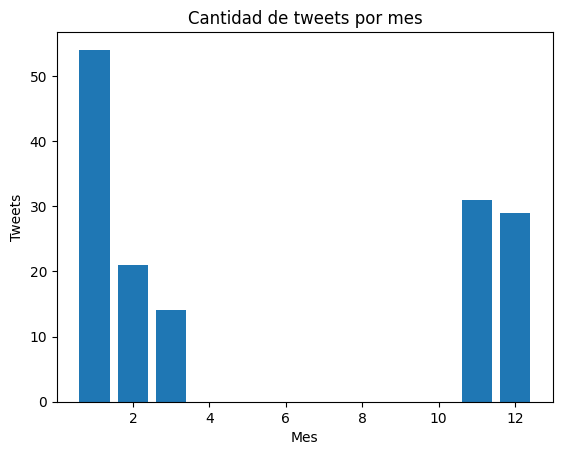

In [25]:
df_tweets_mes = df.groupby(df['created_at'].dt.month)['id_message'].count()

# Crear la figura y los ejes
fig, ax = plt.subplots()

# Crear el gráfico de barras
ax.bar(df_tweets_mes.index, df_tweets_mes.values)

# Establecer el título y las etiquetas de los ejes
ax.set_title("Cantidad de tweets por mes")
ax.set_xlabel("Mes")
ax.set_ylabel("Tweets")

# Mostrar el gráfico
plt.show()

d. ¿Qué palabras son más frecuentes?

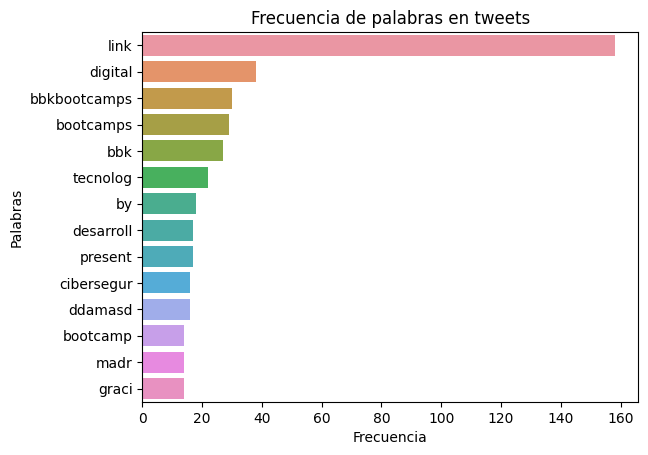

In [26]:
# Datos de las palabras y su frecuencia
palabras = ['link', 'digital', 'bbkbootcamps', 'bootcamps', 'bbk', 'tecnolog', 'by', 'desarroll', 'present', 'cibersegur', 'ddamasd', 'bootcamp', 'madr', 'graci']
frecuencias = [158, 38, 30, 29, 27, 22, 18, 17, 17, 16, 16, 14, 14, 14]

# Crear un DataFrame con los datos
datos = {'Palabras': palabras, 'Frecuencia': frecuencias}
df_palabras = pd.DataFrame(data=datos)

# Crear la figura y los ejes
fig, ax = plt.subplots()

# Crear el gráfico de barras horizontal con Seaborn
sns.barplot(x='Frecuencia', y='Palabras', data=df_palabras, ax=ax)

# Establecer el título y las etiquetas de los ejes
ax.set_title("Frecuencia de palabras en tweets")
ax.set_xlabel("Frecuencia")
ax.set_ylabel("Palabras")

# Mostrar el gráfico
plt.show()

('link', 158)

('digital', 38)

('bbkbootcamps', 30)

('bootcamps', 29)

('bbk', 27)

('tecnolog', 22)

('by', 18)

('desarroll', 17)

('present', 17)

('cibersegur', 16)

('ddamasd', 16)

('bootcamp', 14)

('madr', 14)

('graci', 14)

In [27]:
signos = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\¿)|(\@)|(\#)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")
spanish_stopwords = set(stopwords.words('spanish'))

def signs_tweets(tweet):
    return signos.sub('', tweet.lower())

def remove_links(df):
    return " ".join(['{link}' if ('http') in word else word for word in df.split()])

def remove_stopwords(df):
    return " ".join([word for word in df.split() if word not in spanish_stopwords])

def spanish_stemmer(x):
    stemmer = SnowballStemmer('spanish')
    return " ".join([stemmer.stem(word) for word in x.split()])

def remove_emojis(text):
    return demoji.replace_with_desc(text, '')

In [28]:
# Eliminamos signos de puntuación
df['text'] = df['text'].apply(signs_tweets)

# Eliminamos links
df['text'] = df['text'].apply(remove_links)

# Eliminamos stopwords
df['text'] = df['text'].apply(remove_stopwords)

# Aplicamos el Stemmer
df['text'] = df['text'].apply(spanish_stemmer)

# Eliminamos los emojis
df['text'] = df['text'].apply(remove_emojis)

In [29]:
palabras = [word.lower() for text in df["text"] for word in word_tokenize(text) if word.lower() not in spanish_stopwords and word.isalpha()]

# Cuenta la frecuencia de cada palabra
frecuentes = Counter(palabras)

# Mostramos las palabras más frecuentes
print(frecuentes.most_common(20))

[('link', 158), ('digital', 38), ('bootcamps', 29), ('bbkbootcamps', 29), ('bbk', 27), ('tecnolog', 22), ('arrow', 21), ('right', 19), ('face', 19), ('by', 18), ('desarroll', 17), ('present', 17), ('cibersegur', 16), ('index', 16), ('pointing', 16), ('ddamasd', 16), ('bootcamp', 14), ('madr', 14), ('graci', 14), ('edemempresari', 13)]


### e. ¿Qué tipo de correlación matemática encuentras entre las métricas públicas?

Like: se utilizan para indicar que te interesa un Tweet.

Impresiones: cantidad de veces que a un usuario se le publica un Tweet en la cronología o en los resultados de búsqueda.

Retweet: consiste en publicar nuevamente un Tweet.

Reply: es cuando queremos responder al Tweet de otro usuario de forma pública.

Quote: se trata básicamente de un “Retweet” con comentario, que lo separa de los tradicionales.

-

En general están todas relacionadas ya que es la forma en que los usuarios interactúan con los tweets.

Las métricas que más correlan son los Likes con Impresiones y con Retweets. Es normal ya que si te gusta un Tweet lo lógico es que lo vuelvas a Retwittear. También es normal que salga muchas veces en las búsquedas.

Las métricas que menos correlan son las Quotes y las Replys aunque tampoco es muy baja la correlación.

En definitiva, la correlación matemática entre las métricas públicas de Twitter depende de varios factores y creo que pueden variar significativamente de Tweet a Tweet.

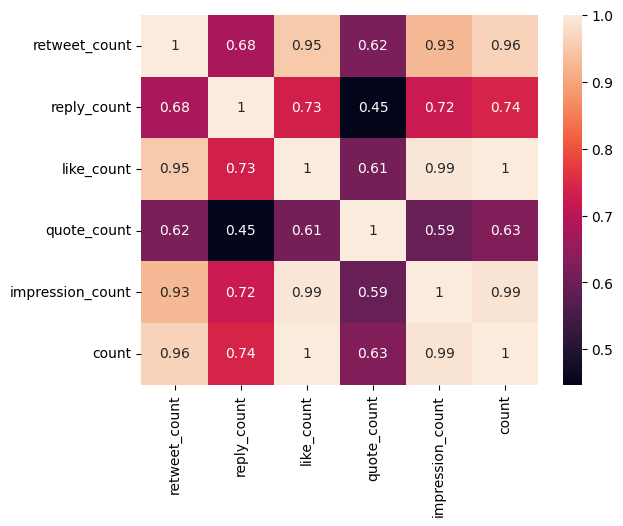

In [30]:
sns.heatmap(df.corr(), annot=True);

<Figure size 500x500 with 0 Axes>

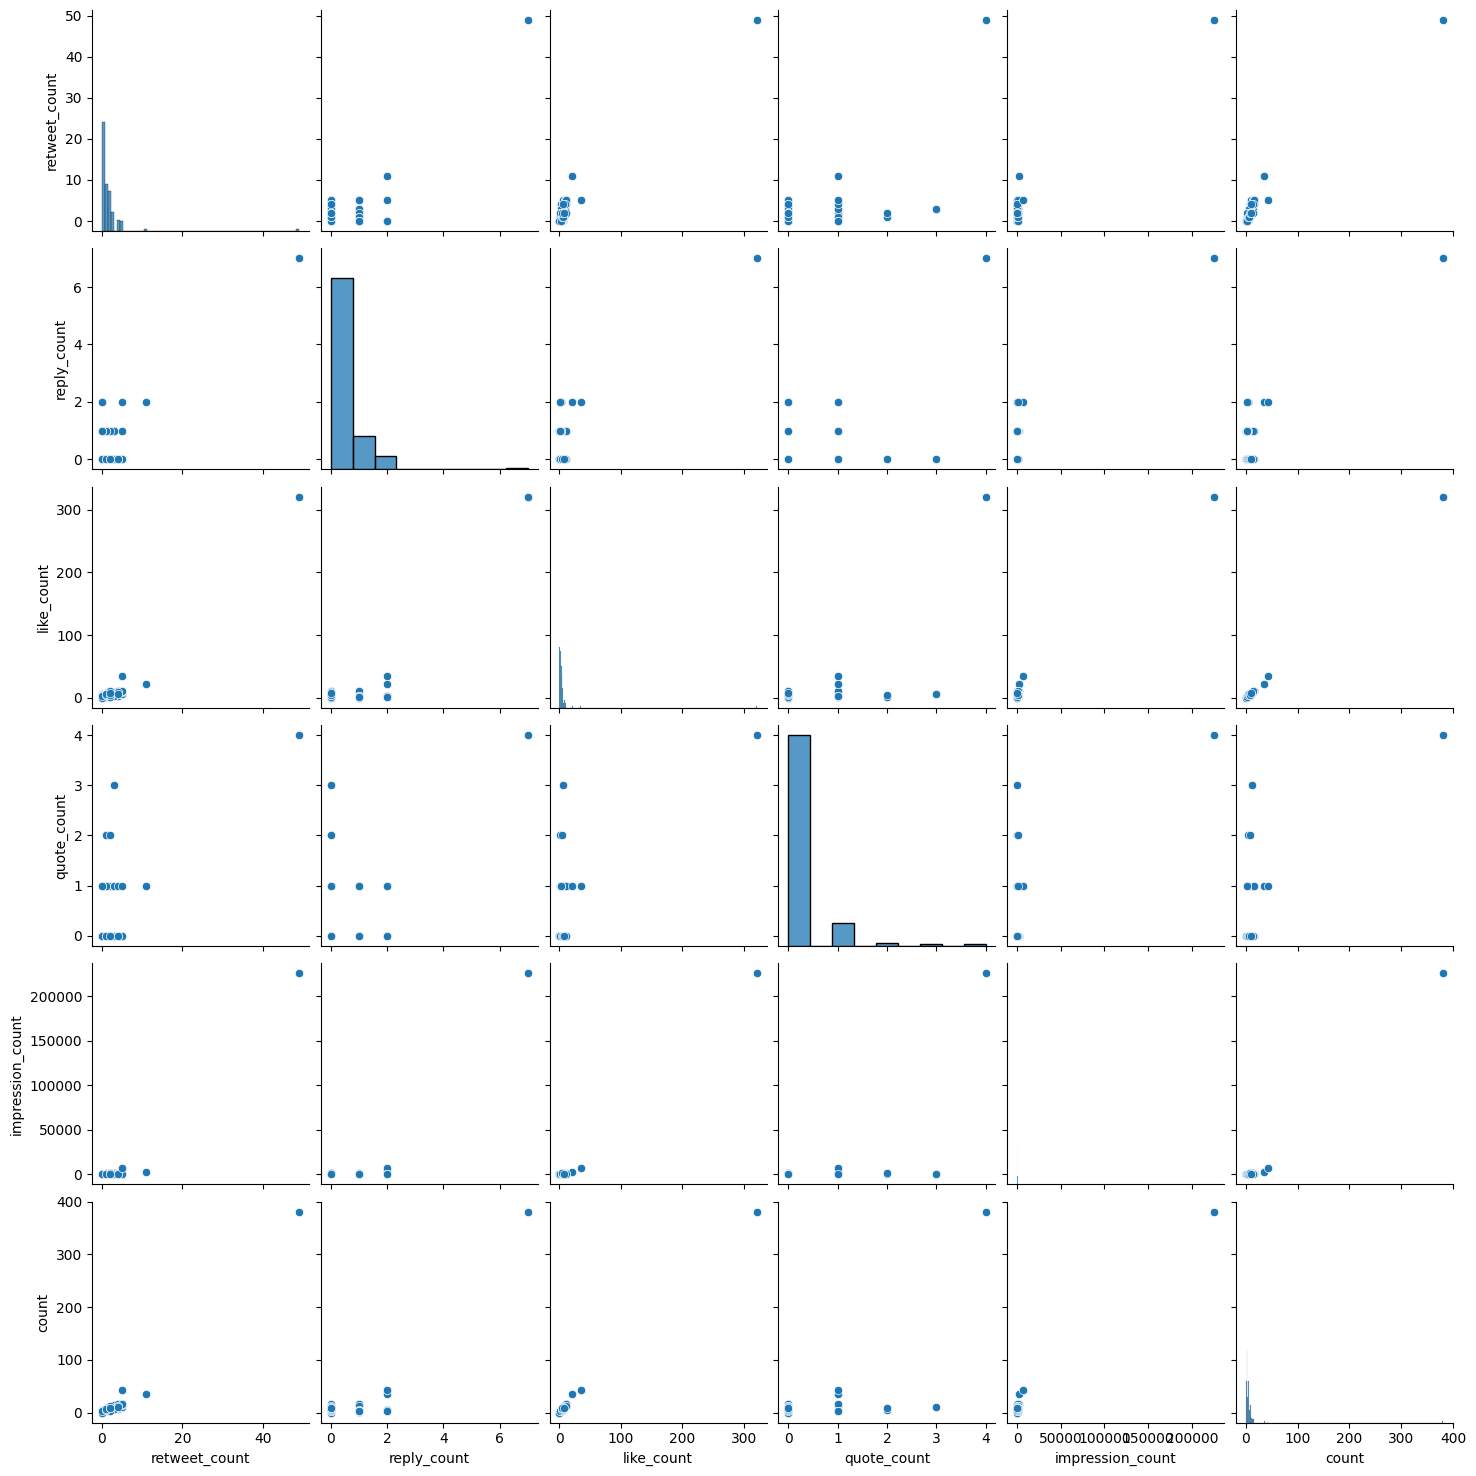

In [31]:
plt.figure(figsize=(5, 5))
sns.pairplot(df,
            kind='scatter',
            # palette=['red', 'green']
            );

### f. ¿Has sacado alguna conclusión extra en tu análisis?

La conclusión que saco de todo esto es que es una red social muy importante en nuestros días. Tener una cuenta de empresa en Twitter puede ser beneficioso para las empresas que buscan aumentar su visibilidad, interactuar con su audiencia, promocionar su marca y servicios, y obtener datos analíticos para mejorar su estrategia de redes sociales. Aunque requiere mucho tiempo y dedicación para poder conseguir una buena estrategia.

### ENTRENAMIENTO

Utiliza el modelo pre entrenado que se te ha facilitado de análisis de sentimiento para determinar el sentimiento de los tweets. 

### a. ¿Cuáles son las predicciones? Interpreta los resultados.

In [31]:
# Función para importar el modelo de pre-entrenado
filename_model = 'model/sentiment_model'
with open(filename_model, 'rb') as archivo:
    modelo_importado = pickle.load(archivo)

modelo_importado

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.5, max_features=1000, min_df=5,
                                 ngram_range=(1, 2))),
                ('cls', LogisticRegression(C=0.5))])

El modelo utilizado para analizar los sentimientos de los tweets es un modelo de clasificación binaria basado en un algoritmo de regresión logística. Este modelo está construido con un pipeline, que combina dos etapas de preprocesamiento y modelado: un vectorizador de conteo de palabras (CountVectorizer) y un clasificador de regresión logística (LogisticRegression).

In [32]:
tweets = df['text'].tolist()
# tweets

In [33]:
pred = modelo_importado.predict(tweets)
pred

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1], dtype=int64)

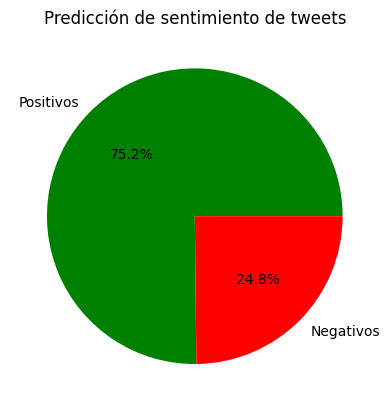

In [34]:
negativos = sum(pred)
positivos = len(pred) - negativos
# positivos = sum(pred)
# negativos = len(pred) - positivos

total = len(pred)
porcentaje_positivos = positivos / total * 100
porcentaje_negativos = negativos / total * 100

fig, ax = plt.subplots()
#ax.pie([positivos, negativos], labels=['Positivos ({:.1f}%)'.format(porcentaje_positivos), 'Negativos ({:.1f}%)'.format(porcentaje_negativos)], colors=['green', 'red'], autopct='%1.1f%%')
ax.pie([positivos, negativos], labels=['Positivos', 'Negativos'], colors=['green', 'red'], autopct='%1.1f%%')
ax.set_title('Predicción de sentimiento de tweets')

plt.show()

### b. ¿Qué variables son las más importantes del modelo?

Las variables más importantes para este modelo son las palabras que se utilizan en los tweets. Gracias al vectorizador de conteo de palabras, las palabras que aparecen con más frecuencia en los tweets pueden tener un impacto significativo en la precisión del modelo.

### c. ¿Cómo podrías mejorar el modelo?

Se podrían probar diferentes valores de los parámetros del modelo, como el número de características máximas (max_features) o el rango de n-gramas (ngram_range) utilizados por el vectorizador de conteo de palabras. También se podrían probar diferentes algoritmos de clasificación, como Random Forest o Naive Bayes.

### d. ¿Qué otras oportunidades se te ocurren donde se podrían aplicar otros modelos de ML?

- Predicción de la intención del cliente en campañas de Telemarketing.
- Clasificación de spam en correos electrónicos.
- Detección de fraude en transacciones financieras.